# Intro.
영상에대해 SURF 피쳐 모두 뽑아서 DCGAN desc를 뽑은 all_desc 로 테스트


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import configparser
import scipy.io as sio

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# real correspondence list  (dist: 0 ~ 1)
cc_real_corr_list = [[295, 2452], [297, 2450], [299, 2448], [308, 2439], [350, 1398], [351, 1399], [352, 1400], [353, 1401], [354, 1402], [355, 1403], [384, 1440], [385, 1441], [389, 1447], [390, 1448], [391, 1449], [392, 1450], [393, 1451], [394, 1452], [395, 1453], [400, 1460], [401, 1461], [525, 1601], [527, 1603], [528, 1604], [530, 1608], [531, 1609], [532, 1610], [535, 1611], [535, 1613], [536, 1614], [537, 1615], [538, 1616], [539, 1617], [540, 1618], [541, 1617], [541, 1619], [543, 1619], [544, 1620], [545, 1621], [547, 1623], [701, 1769], [702, 1770], [703, 1771], [704, 1772], [705, 1773], [706, 1774], [707, 1775], [709, 1777], [748, 1818], [749, 1819], [750, 1819], [750, 1820], [853, 1929], [939, 2017], [940, 2018], [941, 2019], [942, 2020], [943, 2021], [944, 2022], [945, 2023], [946, 2024], [947, 2025], [948, 2026], [949, 2027], [950, 2028], [951, 2029], [952, 2030], [953, 2031], [954, 2032], [955, 2033], [956, 2034], [957, 2035], [958, 2036], [959, 2037], [960, 2038], [961, 2039], [962, 2040], [963, 2041], [964, 2042], [965, 2043], [985, 2063], [986, 2064], [987, 2065], [988, 2066], [989, 2067], [990, 2068], [991, 2069], [992, 2070], [993, 2071], [994, 2072], [995, 2073], [996, 2074], [1002, 2080], [1003, 2081], [1004, 2082], [1005, 2083], [1073, 2149], [1148, 2222], [1205, 2283], [1206, 2284], [1207, 2285], [1216, 2294], [1225, 2303], [1226, 2304], [1227, 2305], [1228, 2306], [1228, 2308], [1229, 2307], [1230, 2310], [1231, 2311], [1232, 2312], [1233, 2313], [1241, 2319], [1242, 2320], [1243, 2321], [1244, 2322], [1245, 2323], [1247, 2325], [1248, 2326], [1273, 2353], [1275, 2355], [1284, 2362], [1285, 2363], [1286, 2364], [1287, 2365], [1288, 2366], [1289, 2367], [1290, 2368], [1291, 2369], [1296, 2374], [1300, 2378], [1301, 2379], [1302, 2378], [1302, 2380], [1303, 2379], [1303, 2381], [1305, 2381], [1306, 2382], [1341, 2423], [1345, 2425], [1347, 2427], [1348, 2428],[295, 2452], [299, 2448], [354, 1402], [384, 1440], [389, 1447], [391, 1449], [541, 1617], [702, 1770], [704, 1772], [706, 1774], [709, 1777], [748, 1818], [750, 1819], [750, 1820], [1233, 2313], [1273, 2353], [1274, 2354], [1345, 2425], [1347, 2427]]

In [3]:
len(np.unique(cc_real_corr_list))

274

In [4]:
# import shutil
# Manual_LC_dataset = np.unique(np.array(cc_real_corr_list).flatten())
# for idx in Manual_LC_dataset:
#     src = "/media/dongwonshin/Ubuntu Data/Datasets/FAB-MAP/Image Data/City Centre/images/%04d.jpg" % idx
#     dst = "/media/dongwonshin/Ubuntu Data/Datasets/FAB-MAP/Image Data/City Centre ManualLC/images/"
#     shutil.copy(src,dst)

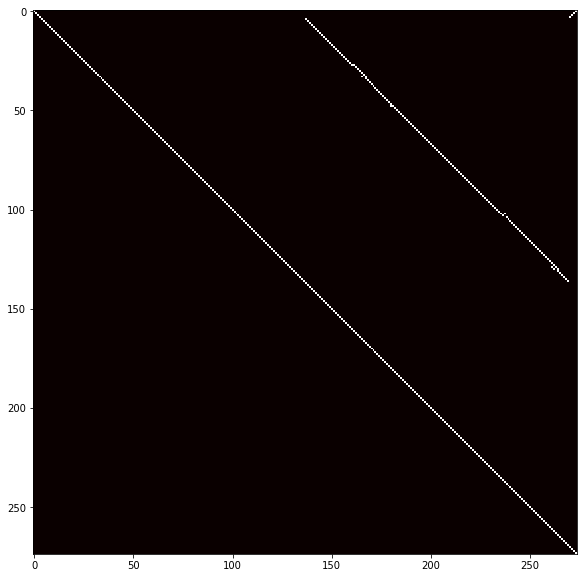

In [5]:
image_idx_order = np.unique(cc_real_corr_list)

GT_corr_mat = np.zeros((len(image_idx_order),len(image_idx_order)))

for a, i in enumerate(image_idx_order):
    for b, j in enumerate(image_idx_order):
        if i==j:
            GT_corr_mat[a,b] = 1
        if [i,j] in cc_real_corr_list:
            GT_corr_mat[a,b] = 1


plt.figure(figsize=(10,10))
plt.imshow(GT_corr_mat, cmap = 'hot')
plt.show()

In [6]:
def PrecisionRecallCurve(GT_corr_mat, esti_corr_mat):

    precision, recall, _ = precision_recall_curve(GT_corr_mat.flatten(), esti_corr_mat.flatten())
    average_precision = average_precision_score(GT_corr_mat.flatten(), esti_corr_mat.flatten())


    # Plot Precision-Recall curve
    plt.clf()
    plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    plt.legend(loc="lower left")
    plt.show()
    
    return precision, recall
    
    
def theLatestResult(path_pattern):
    result_dirs = sorted(glob(path_pattern))
    the_latest_result_path = result_dirs[-1]
    print(the_latest_result_path)
    corr_mat_path = the_latest_result_path + '/corr_matrix.txt'
    param_cfg_path = the_latest_result_path + '/parameters.cfg'
    
    config = configparser.ConfigParser()
    config.read(param_cfg_path)
    print(dict(config.items('General')))
    

    return corr_mat_path, param_cfg_path

def theSpecificResult(path):
    corr_mat_path = path + '/corr_matrix.txt'
    param_cfg_path = path + '/parameters.cfg'
    
    config = configparser.ConfigParser()
    config.read(param_cfg_path)
    print(dict(config.items('General')))
    
    return corr_mat_path, param_cfg_path

# Proposed method

{'method': 'proposed_method', 'scoring type': 'L1_NORM', 'dataset': 'City Centre', 'network model': 'bigger_feature_size'}


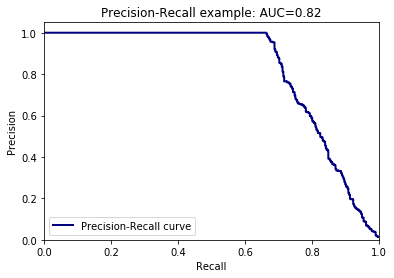

In [7]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBoW2/build2/result/2017-08-23-14-36-15/')
esti_corr_mat = np.loadtxt(corr_mat)
prop_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

{'dataset': 'City Centre', 'scoring type': 'L1_NORM', 'method': 'proposed_method', 'test data': '1000desc', 'network model': 'bigger_feature_size'}


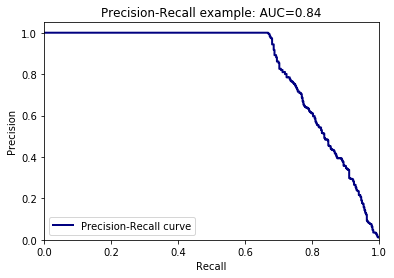

In [9]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBoW2/build2/result/2017-08-25-10-54-33/')
esti_corr_mat = np.loadtxt(corr_mat)
prop_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

{'test data': 'all_desc', 'method': 'proposed_method', 'scoring type': 'L1_NORM', 'dataset': 'City Centre', 'network model': 'bigger_feature_size'}


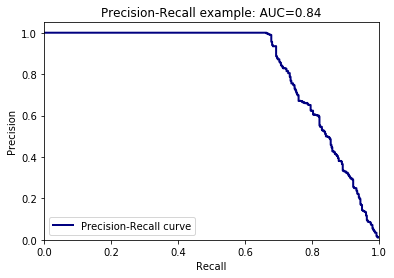

In [9]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBoW2/build2/result/2017-08-30-22-34-28/')
esti_corr_mat = np.loadtxt(corr_mat)
prop_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

# SURF

{'dataset': 'City Centre', 'scoring type': 'L1_NORM', 'method': 'SURF', 'surf params': '{300,4,2}'}


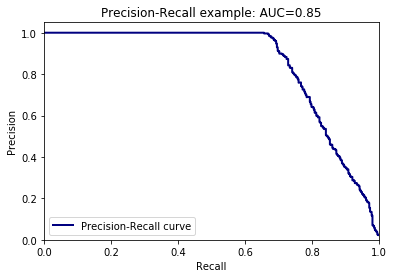

In [10]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBoW2/build2/result/2017-08-23-14-59-26')
esti_corr_mat = np.loadtxt(corr_mat)
surf_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

# SURF (EXTENDED_SURF=true)

{'dataset': 'City Centre', 'scoring type': 'L1_NORM', 'method': 'SURF', 'surf params': '{300,4,2}', 'test data': 'online_survey'}


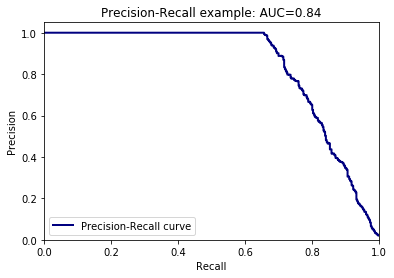

In [11]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBoW2/build2/result/2017-08-24-23-02-45')
esti_corr_mat = np.loadtxt(corr_mat)
surf_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

# ORB

{'dataset': 'City Centre', 'scoring type': 'L1_NORM', 'method': 'orb'}


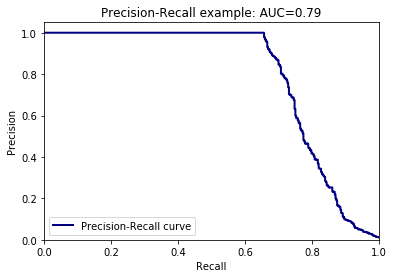

In [12]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBow3/build2/result/2017-08-23-15-45-04')
esti_corr_mat = np.loadtxt(corr_mat)
orb_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

# BRISK

{'dataset': 'City Centre', 'scoring type': 'L1_NORM', 'method': 'brisk'}


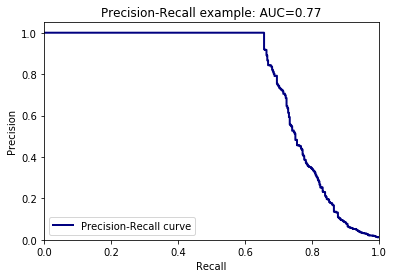

In [13]:
corr_mat, param_cfg = theSpecificResult('/home/dongwonshin/Desktop/DBow3/build2/result/2017-08-23-15-45-36')
esti_corr_mat = np.loadtxt(corr_mat)
brisk_result = PrecisionRecallCurve(GT_corr_mat, esti_corr_mat)

# Fisher Vector

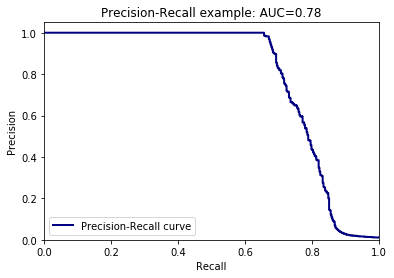

In [14]:
# city centre, vlfeat, FV 방법
mat_contents = sio.loadmat('vlfeat_results/20170825/FV_CC_corr_matrix.mat')
corr_matrix = mat_contents['corr_matrix']
fv_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)

# VLAD

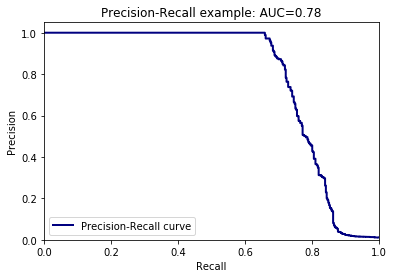

In [15]:
# city centre, vlfeat, VLAD 방법
mat_contents = sio.loadmat('vlfeat_results/20170825/vlad_CC_corr_matrix.mat')
corr_matrix = mat_contents['corr_matrix']
vlad_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)

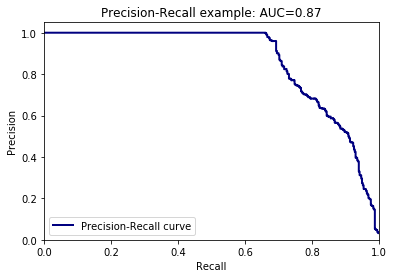

In [16]:
# city centre, vlfeat, bovw-SIFT 방법
mat_contents = sio.loadmat('vlfeat_results/20170825/bovw_CC_corr_matrix.mat')
corr_matrix = mat_contents['corr_matrix']
sift_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)

# 최종결과

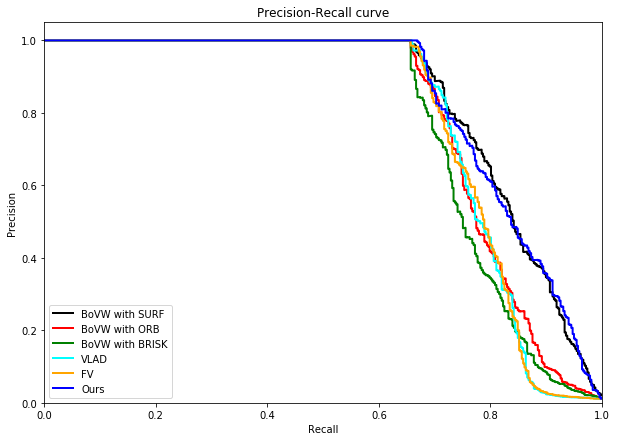

In [18]:
# Plot Precision-Recall curve
plt.figure(figsize=(10,7))
plt.clf()
plt.plot(surf_result[1], surf_result[0], lw=2, color='black', label='BoVW with SURF')
plt.plot(orb_result[1], orb_result[0], lw=2, color='red', label='BoVW with ORB')
plt.plot(brisk_result[1], brisk_result[0], lw=2, color='green', label='BoVW with BRISK')
# plt.plot(sift_result[1], sift_result[0], lw=2, color='magenta', label='BoVW with SIFT')
plt.plot(vlad_result[1], vlad_result[0], lw=2, color='cyan', label='VLAD')
plt.plot(fv_result[1], fv_result[0], lw=2, color='orange', label='FV')
plt.plot(prop_result[1], pro03p_result[0], lw=2, color='blue', label='Ours')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()